In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [3]:
##Paramètres
mu = 30e9
sigma = 100e6
rho = 2400

a = 2e-4
b = 1e-3
v0 = 1e-9
dc = 1e-3
taubdot = 1e-2 #Pa.s-1

eta = np.sqrt(mu*rho/2) #=6000000
Lb = mu*dc/(b*sigma) #=300

alpha = a/b 
beta = eta*v0/(b*sigma) #=6e-08
taubbardot = 0#dc*taubdot/(b*sigma*v0) #=0.1

deltaX = int(Lb/4) #=75
#deltaX < Lb
#L > Lb
N = 10000
I = 64
L = I * deltaX
h = 1e-2


##Calcul du gradient de la transformée de Hilbert (cf. doc)
def hilbert_grad(f, deltaX) :
    """
    Renvoie la transformée de Hilbert du gradient par rapport à l'espace de la fonction f
    f est un tableau de taille I qui représente f à un instant en tout point
    """
    F=np.fft.fft(f)
    k=np.fft.fftfreq(len(f),deltaX)

    F=np.abs(k*2*np.pi)*F

    hh=np.fft.ifft(F)
    return hh.real*Lb

##Résolution numérique de l'équation différentielle (cf. doc)
def RKF(f, yk, h=1e-2, dtmin=1e-16, dtmax=1e2, tol=1e-10):
    K = 0
    t0 = time.time()
    if h > dtmax:   #Cela empêche la fonction de marcher si c'est le cas.
        h = dtmax/2
    s = 1.
    ykk = yk
    while s*h < dtmax and K < 30:
        k1 = h * f(yk)
        k2 = h * f(yk + k1/4)
        k3 = h * f(yk + 3*k1/32 + 9*k2/32)
        k4 = h * f(yk + 1932*k1/2197 - 7200*k2/2197 + 7296*k3/2197)
        k5 = h * f(yk + 439*k1/216 - 8*k2 + 3680*k3/513 - 845*k4/4104)
        k6 = h * f(yk - 8*k1/27 + 2*k2 - 3544*k3/2565 + 1859*k4/4104 - 11*k5/40)
        ykk = yk + 25*k1/216 + 1408*k3/2565 + 2197*k4/4104 - k5/5
        #print('ykk='+str(ykk))
        zkk = yk + 16*k1/135 + 6656*k3/12825 + 28561*k4/56430 - 9*k5/50 + 2*k6/55
        erreur = np.linalg.norm(zkk - ykk)
        tf = time.time()
        K = K + 1
        s = (tol / (2 * erreur))**0.25
        print(erreur)
        print(K)
        if erreur < tol:
            #print(tf-t0)
            return ykk, s*h
        if s*h < dtmin:
            #print(tf-t0)
            return ykk, h
        h = s*h
        #print(tf-t0)
    if K==30 and erreur == tol:
        raise ValueError("Trop d'iterations")
    return ykk, h

##Système différentiel
def phidot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    H = hilbert_grad(v, deltaX)
    return (v - 1/theta - 1/2*H + taubbardot*np.ones(I+1))/(alpha+beta*v)
    
def nudot(phi, nu):
    v = np.exp(phi)
    theta = np.exp(nu)
    return 1/theta - v

def F(y):
    phi = y[0]
    nu = y[1]
    F1 = phidot(phi, nu)
    F2 = nudot(phi, nu)
    return np.array([F1, F2])


##Conditions initiales
x = np.arange(-L//2, L//2 + 1, deltaX)
d = 500 #largeur de la zone de glissemnt initiale
amp = 50 #amplitude max
temps = np.array([0])

#Elliptique
Ae = []
for y in x :
    if y < d and y > -d:
        Ae.append((np.sqrt(d**2 - y**2)/d)*amp + 1)
    else :
        Ae.append(1)
        
Ae = np.array(Ae)
Be = 1/Ae

#Gaussienne
Ag = np.exp(-x**2/(d*500))*amp + np.ones(I+1)
Bg = 1/Ag

#Carré
Ac = []
for y in x :
    if y < d and y > -d:
        Ac.append(amp)
    else :
        Ac.append(1)

Ac = np.array(Ac)
Bc = 1/Ac

#Uniformes
Au = np.ones(I+1)*amp
Bu = 1/Au

##Résolution
CIv = Ag
CItheta = Bg

phik = np.log(CIv)
nuk = np.log(CItheta)

yk = np.array([phik, nuk])

Phi = [phik]
Nu = [nuk]

tg0 = time.time()
for n in range(N):
    if n%1000 == 0:
        print(n)
    res = RKF(F, yk, h)
    yk = res[0]
    h = res[1]
    temps = np.concatenate((temps, [temps[n]+h]))
    Phi.append(yk[0])
    Nu.append(yk[1])
tgf = time.time()
print(f"Run time = {tgf - tg0}s")

0
0.00158713877473353
1
1.3317335090070948e-12
2
1.1732722447960017e-10
1
4.061730479436245e-11
2
4.903476559003209e-11
1
4.6769048897832775e-11
1
4.7248695398709406e-11
1
4.693088797134899e-11
1
4.6754005848709344e-11
1
4.650076527536761e-11
1
4.622532648496444e-11
1
4.5925140211305086e-11
1
4.5590863209788896e-11
1
4.522181846442038e-11
1
4.48060460896243e-11
1
4.433333262967709e-11
1
4.3786216919615227e-11
1
4.314200383634013e-11
1
4.2361403175567675e-11
1
4.1405152405209754e-11
1
4.018524151393274e-11
1
3.861169496462481e-11
1
3.6609923886849226e-11
1
3.468671210976998e-11
1
3.729611352149198e-11
1
5.393521835611814e-11
1
5.993192877263067e-11
1
5.499639996820565e-11
1
5.229442723205184e-11
1
5.041765218560413e-11
1
4.916254852033067e-11
1
4.824126099661236e-11
1
4.7540907665739396e-11
1
4.6993258239429824e-11
1
4.657262433521348e-11
1
4.625515453068057e-11
1
4.604430940375573e-11
1
4.593394717271853e-11
1
4.592044500000301e-11
1
4.599542598494327e-11
1
4.61378562954306e-11
1
4.632

5.839444098096089e-11
1
5.839607047840507e-11
1
5.838683152569656e-11
1
5.838471709932954e-11
1
5.837684882684226e-11
1
5.837288809617389e-11
1
5.836627711886449e-11
1
5.835750065131798e-11
1
5.835545830685103e-11
1
5.834664975311686e-11
1
5.833528654664318e-11
1
5.833022276562159e-11
1
5.831715670354451e-11
1
5.830663531543831e-11
1
5.829997744654096e-11
1
5.828264273088331e-11
1
5.82702289136443e-11
1
5.825989402013706e-11
1
5.82372221458276e-11
1
5.822968574191723e-11
1
5.8203111755633034e-11
1
5.818874640312793e-11
1
5.816357683355274e-11
1
5.8144536187554066e-11
1
5.812075988218282e-11
1
5.80926676910605e-11
1
5.806305610618081e-11
1
5.803520698184834e-11
1
5.8011062413465073e-11
1
5.7969598292348656e-11
1
5.7938447778002726e-11
1
5.790567514770843e-11
1
5.786531199385096e-11
1
5.782567071515661e-11
1
5.778619320726223e-11
1
5.774239948911953e-11
1
5.770084064058872e-11
1
5.765115823919289e-11
1
5.7606039214636706e-11
1
5.7558449098650545e-11
1
5.750993926626482e-11
1
5.7452906068

5.440540030409091e-11
1
5.367822071329461e-11
1
5.307692988738108e-11
1
5.256503851627955e-11
1
5.2117018138252364e-11
1
5.1713860928856846e-11
1
5.138059303877629e-11
1
5.1079066825144485e-11
1
5.0846144538318933e-11
1
5.068438708506531e-11
1
5.061625919243957e-11
1
5.066283374171449e-11
1
5.0852363036061144e-11
1
5.115320466616512e-11
1
5.1567051500114206e-11
1
5.1991695372171437e-11
1
5.23797650850804e-11
1
5.2664883847853003e-11
1
5.2810975406154926e-11
1
5.283552864823957e-11
1
5.2750672474656895e-11
1
5.259917275538223e-11
1
5.2394883063975345e-11
1
5.2175291396859225e-11
1
5.1944528195242064e-11
1
5.1714407637372614e-11
1
5.14994772960544e-11
1
5.1286836703498746e-11
1
5.109867135186351e-11
1
5.09154549655133e-11
1
5.075155087921448e-11
1
5.059871819003026e-11
1
5.0461710784559024e-11
1
5.03345492283274e-11
1
5.021474198205976e-11
1
5.011320597626216e-11
1
5.000822974063347e-11
1
4.992319266049216e-11
1
4.983143895836786e-11
1
4.975058025594294e-11
1
4.9675608956398976e-11
1
4.9

4.943009656382405e-11
1
4.937568876068527e-11
1
4.9333019398389263e-11
1
4.928671906984846e-11
1
4.9264129701070044e-11
1
4.921230101676176e-11
1
4.9188729817625484e-11
1
4.916024337168282e-11
1
4.913587097016875e-11
1
4.911850681096774e-11
1
4.909652504725514e-11
1
4.9095978482625626e-11
1
4.9078953713410324e-11
1
4.9080360422345097e-11
1
4.909251805209351e-11
1
4.9079199050925856e-11
1
4.909753749762216e-11
1
4.91009096628313e-11
1
4.910688022661415e-11
1
4.911353811775999e-11
1
4.911492027790969e-11
1
4.911849781716528e-11
1
4.911871565957149e-11
1
4.9111593248826566e-11
1
4.910765856451173e-11
1
4.9106322453509754e-11
1
4.911436329605252e-11
1
4.91091419216428e-11
1
4.9140097528878716e-11
1
4.9185700969656876e-11
1
4.927052417193204e-11
1
4.9386431412535093e-11
1
4.9564897523238884e-11
1
4.980981895497645e-11
1
5.013703249006168e-11
1
5.052195080374245e-11
1
5.09673996830603e-11
1
5.143215026843389e-11
1
5.1879005643683344e-11
1
5.2260643057240535e-11
1
5.2576002078363246e-11
1
5.2

4.900257899985466e-11
1
4.8934204276150334e-11
1
4.888911042628935e-11
1
4.884310693605191e-11
1
4.878340220828483e-11
1
4.873847490879894e-11
1
4.869387460522498e-11
1
4.86399126509728e-11
1
4.8606137243549883e-11
1
4.855810349752518e-11
1
4.851136195674166e-11
1
4.848083555361731e-11
1
4.843592015398911e-11
1
4.8405620034462343e-11
1
4.8365354230423487e-11
1
4.8331236119420335e-11
1
4.83100173687548e-11
1
4.827198869699167e-11
1
4.824989224428941e-11
1
4.82280880265314e-11
1
4.8202805277552076e-11
1
4.818384527697379e-11
1
4.8165194915581034e-11
1
4.81515565813492e-11
1
4.812452331949478e-11
1
4.811733307152012e-11
1
4.8093933596203675e-11
1
4.808360541538462e-11
1
4.806260806364229e-11
1
4.804375311629376e-11
1
4.802985335308649e-11
1
4.799794872454834e-11
1
4.799138861518304e-11
1
4.794889864378384e-11
1
4.794707103282871e-11
1
4.790529179277599e-11
1
4.791594431597018e-11
1
4.791790102221506e-11
1
4.796229584807421e-11
1
4.8087198770775506e-11
1
4.8327624824371806e-11
1
4.87581573

5.236320629140648e-11
1
5.219364116313949e-11
1
5.201368685438165e-11
1
5.187338194497744e-11
1
5.169741473103019e-11
1
5.156072618214731e-11
1
5.14193447482488e-11
1
5.12847972887093e-11
1
5.1157418344030094e-11
1
5.104069096047924e-11
1
5.092461691781662e-11
1
5.0804557222274955e-11
1
5.070479687684616e-11
1
5.060911438270108e-11
1
5.0498398046216784e-11
1
5.0412512553684555e-11
1
5.0315195767657897e-11
1
5.0230308004302716e-11
1
5.014053514561252e-11
1
5.0063911006401184e-11
1
4.9982163106464407e-11
1
4.990286584562435e-11
1
4.9836598611199e-11
1
4.975538405516597e-11
1
4.9686247480939355e-11
1
4.962765838267324e-11
1
4.9543803664931904e-11
1
4.949827174125319e-11
1
4.942461453769883e-11
1
4.936895585254105e-11
1
4.9302949824712735e-11
1
4.924728565091156e-11
1
4.919879827970408e-11
1
4.913324109430759e-11
1
4.908514046779766e-11
1
4.9026562817558677e-11
1
4.898606974565112e-11
1
4.893016962561155e-11
1
4.8874852917887065e-11
1
4.883632067817688e-11
1
4.879347981164163e-11
1
4.87381

4.919724630985946e-11
1
4.9194995505822465e-11
1
4.919936784147906e-11
1
4.9202796937981146e-11
1
4.9202550031520984e-11
1
4.91961540169885e-11
1
4.9202972657668246e-11
1
4.91958705171648e-11
1
4.921350340605352e-11
1
4.9193317918930525e-11
1
4.919866824257676e-11
1
4.9199861813369966e-11
1
4.921121923352987e-11
1
4.919548156814212e-11
1
4.920061398539932e-11
1
4.920879298559442e-11
1
4.919575904099477e-11
1
4.920635712726884e-11
1
4.920312965049293e-11
1
4.91986714494151e-11
1
4.9204323882616587e-11
1
4.919827174747302e-11
1
4.920417984778009e-11
1
4.919538163648177e-11
1
4.9200078076833164e-11
1
4.920627453194921e-11
1
4.920762310122536e-11
1
4.919663711744898e-11
1
4.919464477853717e-11
1
4.9206483072039027e-11
1
4.9198617574503145e-11
1
4.9197021695889887e-11
1
4.9197392417425105e-11
1
4.920291198955524e-11
1
4.9196848263956485e-11
1
4.91984621065693e-11
1
4.920046840047595e-11
1
4.9190638818340546e-11
1
4.919944749814898e-11
1
4.9201164510571845e-11
1
4.91909147789848e-11
1
4.9194

4.739740775074866e-11
1
4.736403807833344e-11
1
4.728452756192932e-11
1
4.724201120081576e-11
1
4.715759377245255e-11
1
4.709646282212626e-11
1
4.7016392021719883e-11
1
4.692161962223178e-11
1
4.6842407119815797e-11
1
4.672004656916792e-11
1
4.66229078210863e-11
1
4.6485616091638204e-11
1
4.6356286202773676e-11
1
4.6197955856085407e-11
1
4.602139800204224e-11
1
4.582097313599728e-11
1
4.559166692910006e-11
1
4.534071422981634e-11
1
4.501670110531523e-11
1
4.470222735759873e-11
1
4.420520026290727e-11
1
4.3921844599154467e-11
1
4.275040053574728e-11
1
4.3973478875832865e-11
1
3.6257147519137945e-11
1
7.088550167009151e-11
1
5.5897912795255614e-11
1
2.0056466014321338e-10
1
2.842371686478427e-11
2
8.509642954917576e-12
1
2.252576738149388e-10
1
2.357064082047488e-11
2
2.4640458299330722e-11
1
5.6430002881035835e-11
1
1.7905807213897883e-10
1
3.2507338897204586e-11
2
9.806939604007371e-11
1
5.89860788174147e-11
1
4.2777306163982684e-11
1
1.8048103341485326e-11
1
9.669735581480191e-11
1
9.

2.7030652233529925e-11
1
2.6123293563451607e-11
1
6.964034627336813e-11
1
1.1917078638184365e-10
1
3.589232149580864e-11
2
2.6169397719281224e-11
1
5.0128694580535175e-11
1
9.960432073205811e-11
1
7.619545644402438e-11
1
3.116715183084498e-11
1
2.1891598561991604e-11
1
5.432950463427126e-11
1
1.2500838848885644e-10
1
3.514943759579649e-11
2
3.453324666737972e-11
1
5.946481309824084e-11
1
8.19639777209321e-11
1
5.672969408859963e-11
1
3.138991138823845e-11
1
3.215720078780983e-11
1
6.499670479614452e-11
1
9.282356320340749e-11
1
5.600268075061688e-11
1
2.6924251338324494e-11
1
2.951690995111545e-11
1
7.400133807269303e-11
1
1.0898257547318744e-10
1
3.7163028258913064e-11
2
2.501687099024571e-11
1
4.697359239516709e-11
1
1.0093368336950621e-10
1
3.8133152189794955e-11
2
4.325141598771382e-11
1
6.160170705596555e-11
1
6.61976088236979e-11
1
4.768632737705232e-11
1
3.548323151285536e-11
1
4.2733073173665556e-11
1
6.612601092400301e-11
1
6.996450927273655e-11
1
4.5839245747922445e-11
1
3.23

2.82613661465142e-11
1
5.543994647085523e-11
1
9.702659842822437e-11
1
6.773237224161075e-11
1
4000
2.945628291221258e-11
1
2.4546503026425796e-11
1
6.123379073094494e-11
1
1.1842815808543616e-10
1
3.5920031016338066e-11
2
3.0550059257217623e-11
1
5.4359814966234484e-11
1
8.853137068439738e-11
1
6.52681469436528e-11
1
3.181822350607681e-11
1
2.721427075138195e-11
1
5.884369844070738e-11
1
1.0425062061624128e-10
1
3.7723963025616026e-11
2
3.328949021573918e-11
1
5.377692621279629e-11
1
8.049938951670767e-11
1
6.221973206348485e-11
1
3.417260475885149e-11
1
3.042084604418735e-11
1
5.7340202141358975e-11
1
9.167666591611193e-11
1
6.314870144047254e-11
1
2.986216930037746e-11
1
2.71624542949356e-11
1
6.323277996919826e-11
1
1.086450015646274e-10
1
3.716267758663875e-11
2
3.0199842365430076e-11
1
5.192107459165134e-11
1
8.741544957197525e-11
1
6.787484764192385e-11
1
3.315741395503987e-11
1
2.6711916934355925e-11
1
5.5513501884231494e-11
1
1.0304138625827056e-10
1
3.7877124053161615e-11
2
3

3.701528735715932e-11
1
1.9102342495091225e-11
1
4.1201199636520203e-11
1
1.2564724334043088e-10
1
3.500591404944595e-11
2
4.6938032158659435e-11
1
7.068293765396251e-11
1
6.607431361837476e-11
1
4.1110005699428736e-11
1
3.212619641296095e-11
1
4.7808493747235374e-11
1
7.830984530998444e-11
1
6.899055938905466e-11
1
3.785940326249789e-11
1
2.8753113551128145e-11
1
4.9538394928467374e-11
1
8.965517248506872e-11
1
7.230716013443277e-11
1
3.37232619383148e-11
1
2.4942547174473478e-11
1
5.266370031958985e-11
1
1.0737646381447151e-10
1
3.7255634264611927e-11
2
3.744183674916967e-11
1
5.8192522723687435e-11
1
7.446707539134933e-11
1
5.460815962629102e-11
1
3.407959776544908e-11
1
3.555245435230012e-11
1
6.247179226654309e-11
1
8.186441734719039e-11
1
5.385081234715587e-11
1
3.0269607786634e-11
1
3.348760022495081e-11
1
6.913169305330064e-11
1
9.217969710322692e-11
1
5.2325217481681436e-11
1
2.578650827273446e-11
1
3.1313869480417e-11
1
7.990539694752356e-11
1
1.0717330809330652e-10
1
3.74346

1.1350503955975464e-10
1
3.638974315423684e-11
2
4.627768983654521e-11
1
6.73253882153526e-11
1
6.510105936569702e-11
1
4.2892052316133084e-11
1
3.3666000709264714e-11
1
4.6741208892478784e-11
1
7.359666688316947e-11
1
6.800888139371175e-11
1
4.011124791665313e-11
1
3.050180709925847e-11
1
4.7794323978561255e-11
1
8.265515348100031e-11
1
7.134527005114884e-11
1
3.6532073828444005e-11
1
2.6922918071338515e-11
1
4.981058201034475e-11
1
9.633478496218683e-11
1
7.511490777196953e-11
1
3.202052206223757e-11
1
2.279737252620881e-11
1
5.364880805854782e-11
1
1.1901019597544584e-10
1
3.5805003548467645e-11
2
3.55210536661253e-11
1
5.915594027673122e-11
1
7.939298986630434e-11
1
5000
5.5905255569775905e-11
1
3.2210409317359656e-11
1
3.330981792737539e-11
1
6.431183465763788e-11
1
8.89882055688785e-11
1
5.512614255580427e-11
1
2.79430972211599e-11
1
3.0844483587088373e-11
1
7.254003190040183e-11
1
1.0305301452937148e-10
1
3.7957749257148865e-11
2
2.609957163320335e-11
1
4.686560764771763e-11
1
9

4.439355440293125e-11
1
3.2103948104566016e-11
1
4.372493725558257e-11
1
7.46148923852398e-11
1
7.344720210411415e-11
1
4.160903376408132e-11
1
2.8560915563499313e-11
1
4.411330584513e-11
1
8.489666440500767e-11
1
7.864951058861859e-11
1
3.7946713586069753e-11
1
2.4493038347215916e-11
1
4.533730260147022e-11
1
1.0125514420696551e-10
1
3.808418720275281e-11
2
4.4942049203240405e-11
1
6.29847942339494e-11
1
6.449085745949676e-11
1
4.578480645549761e-11
1
3.557364547377889e-11
1
4.48336650497994e-11
1
6.774636681555988e-11
1
6.755458211647507e-11
1
4.364740925372211e-11
1
3.2632116663487393e-11
1
4.503705726472318e-11
1
7.447713820492501e-11
1
7.11540912949095e-11
1
4.083093954398544e-11
1
2.9260716234015487e-11
1
4.5713104448954234e-11
1
8.435208925515448e-11
1
7.556865561392118e-11
1
3.7166234761411375e-11
1
2.5363315869150133e-11
1
4.730466185995732e-11
1
9.988886542200211e-11
1
8.086749783851883e-11
1
3.2417667443531996e-11
1
2.0851196498204246e-11
1
5.0712853976330005e-11
1
1.2677605

2.4457496127768877e-11
1
3.6522795498863365e-11
1
9.11123508631424e-11
1
9.916542620697667e-11
1
4.122604008377061e-11
1
1.93730248949246e-11
1
3.6103244861652565e-11
1
1.1638841673463151e-10
1
3.600713259120873e-11
2
5.528885331298683e-11
1
7.527555068829177e-11
1
5.796534933100645e-11
1
3.50873904343742e-11
1
3.3744611687020516e-11
1
5.881782499620632e-11
1
8.344053320752886e-11
1
5.803404978777262e-11
1
3.124330621753906e-11
1
3.1180748783987375e-11
1
6.431815771271202e-11
1
9.523099944082225e-11
1
5.7554746368125155e-11
1
2.666815149580956e-11
1
2.8275948180972722e-11
1
7.342300110750074e-11
1
1.1319984873836888e-10
1
3.6614383689855435e-11
2
2.4969190557337772e-11
1
4.778599717444265e-11
1
1.0193524677019202e-10
1
3.800646467663772e-11
2
4.2328745662839836e-11
1
6.107110360047258e-11
1
6.737622103174204e-11
1
4.868517613230437e-11
1
3.526609138411716e-11
1
4.1557692823653006e-11
1
6.55285597178917e-11
1
7.164685738817064e-11
1
4.699592393081721e-11
1
3.2082230831516476e-11
1
4.091

2.4853549592316278e-11
1
3.425394156453741e-11
1
8.671923300543697e-11
1
1.027662461329506e-10
1
3.8051930243535126e-11
2
2.0925123769844874e-11
1
4.1621074099395296e-11
1
1.1460059310039318e-10
1
3.624478007580465e-11
2
4.763942678329526e-11
1
6.869678134115554e-11
1
6.39434411282409e-11
1
4.146129288127901e-11
1
3.3588826302946994e-11
1
4.860147696771355e-11
1
7.529647059839237e-11
1
6.62679101122902e-11
1
3.844319963814524e-11
1
3.055933246045299e-11
1
5.0225433138234215e-11
1
8.478231764273318e-11
1
6.889080093623352e-11
1
3.466889371625504e-11
1
2.704422099385215e-11
1
5.3124684651195154e-11
1
9.928211180966943e-11
1
7.173320567534338e-11
1
2.9932135209630824e-11
1
2.3001423480821687e-11
1
5.834750830404057e-11
1
1.2334045916983597e-10
1
3.536459495093528e-11
2
3.1917518791141956e-11
1
5.661138506651275e-11
1
8.652926465480662e-11
1
6.175491520094145e-11
1
3.135477643371729e-11
1
2.8930413912561084e-11
1
6.167216991218907e-11
1
1.0043659429896783e-10
1
3.828399793005706e-11
2
3.18

3.250210861151778e-11
1
4.4398947682030664e-11
1
7.414337188745949e-11
1
7.204340937045439e-11
1
4.134956198997181e-11
1
2.9095037766798214e-11
1
4.489216216231638e-11
1
8.405214594936518e-11
1
7.682299495342895e-11
1
3.7739415727867384e-11
1
2.511922157013481e-11
1
4.620576232802922e-11
1
9.969904956911535e-11
1
8.271622741518481e-11
1
3.302344981407152e-11
1
2.0519967990015082e-11
1
4.9137502877664845e-11
1
1.2703423049954985e-10
1
3.488850067726502e-11
2
3.851850876216692e-11
1
6.358236256949978e-11
1
7.613307678511017e-11
1
5.04515057962901e-11
1
3.1421286379148275e-11
1
3.7110473035369606e-11
1
6.99828934832332e-11
1
8.359335596561977e-11
1
4.8503362444634565e-11
1
2.735936177132107e-11
1
3.572385463633602e-11
1
7.986850706519831e-11
1
9.384812121111327e-11
1
4.560493149717772e-11
1
2.2634086793718036e-11
1
3.453109218212923e-11
1
9.632992603194039e-11
1
1.0845259778113326e-10
1
3.730745570780784e-11
2
1.7862291140606543e-11
1
3.9491319808790574e-11
1
1.3219588111495033e-10
1
3.42

2.709264278148266e-11
1
4.014156129084843e-11
1
8.558181188364339e-11
1
8.694538257775109e-11
1
4.027969615014466e-11
1
2.2577940701561046e-11
1
4.036114518882884e-11
1
1.0413819472647318e-10
1
3.761999045753252e-11
2
5.0566546330579794e-11
1
6.831658794705752e-11
1
5.990955539794378e-11
1
3.993413947288929e-11
1
3.534103106260967e-11
1
5.2214602783740267e-11
1
7.430100957555478e-11
1
6.102763307712019e-11
1
3.687741698310485e-11
1
3.2798209937379106e-11
1
5.476113981349762e-11
1
8.256674386285542e-11
1
6.203640570563098e-11
1
3.316362140364351e-11
1
2.988792021666108e-11
1
5.883275198171885e-11
1
9.464195130401032e-11
1
6.277343846575335e-11
1
2.866675333225015e-11
1
2.6576154403017125e-11
1
6.562629607966711e-11
1
1.1334746363247473e-10
1
3.6579659776562634e-11
2
2.8547746043237576e-11
1
5.133295512691117e-11
1
9.205583533332778e-11
1
7.088517510983337e-11
1
3.229519698550901e-11
1
2.474986784070709e-11
1
5.522456328674969e-11
1
1.1104797845111577e-10
1
3.68068916318531e-11
2
3.51122

2.3415028660350042e-11
1
3.581599360908647e-11
1
9.456212490329518e-11
1
1.0340783867863231e-10
1
3.799289814823949e-11
2
1.8631505325236635e-11
1
3.9350508480898556e-11
1
1.2635035450503362e-10
1
3.4849455465370834e-11
2
4.9237476590231966e-11
1
7.296189935386831e-11
1
6.413490846427805e-11
1
3.892451521514855e-11
1
3.20544112911217e-11
1
5.087148233341376e-11
1
8.111780060257069e-11
1
6.619170194740161e-11
1
3.538806878368942e-11
1
2.888598586174945e-11
1
5.361925266325852e-11
1
9.320289880829908e-11
1
6.830478889637317e-11
1
3.1013793716284376e-11
1
2.523320111263608e-11
1
5.839012803622415e-11
1
1.1220392734004637e-10
1
3.667024012953563e-11
2
3.2844720561271195e-11
1
5.517924765020304e-11
1
8.27963884861517e-11
1
6.163213336202813e-11
1
3.291902031407494e-11
1
2.996907222506289e-11
1
5.941540204079175e-11
1
9.487085206685895e-11
1
6.226643153351305e-11
1
2.8412016418712835e-11
1
2.67011556060398e-11
1
6.648114640553119e-11
1
1.1346214495836534e-10
1
3.656760195022281e-11
2
2.81202

8.251564774838707e-11
1
1.1286156255979379e-10
1
3.67102688343989e-11
2
2.1582814840164854e-11
1
4.4214549138696557e-11
1
1.1425323057296743e-10
1
3.6325584593501374e-11
2
4.4624939603971687e-11
1
6.607420377952873e-11
1
6.684782159032358e-11
1
4.451966636099289e-11
1
3.3489197715209936e-11
1
4.469194925998328e-11
1
7.214049801929529e-11
1
7.036320894656992e-11
1
4.192458033936684e-11
1
3.0219521218493e-11
1
4.514314403617941e-11
1
8.097437917968417e-11
1
7.467031980796929e-11
1
3.8527672903067204e-11
1
2.646378168607362e-11
1
4.6356278034447464e-11
1
9.445048073352508e-11
1
7.977747873667149e-11
1
3.4143884312094086e-11
1
2.2147694578970344e-11
1
4.8893143561682407e-11
1
1.1704302114061274e-10
1
3.6027907563111064e-11
2
3.965764300961558e-11
1
6.236867688154691e-11
1
7.301534395479573e-11
1
5.0134172294171557e-11
1
3.283328567053062e-11
1
3.842713999115214e-11
1
6.793102874423553e-11
1
7.923761421007898e-11
1
4.834750010049116e-11
1
2.9068326984430748e-11
1
3.72353478550518e-11
1
7.62

2.8955104485837227e-11
1
5.581986784872161e-11
1
9.493486740558578e-11
1
6.638035470452158e-11
1
2.975307052087461e-11
1
2.5412266414693425e-11
1
6.150379835241736e-11
1
1.1448981456850397e-10
1
3.640672199909519e-11
2
3.0742718032704816e-11
1
5.364227936510894e-11
1
8.73208099519975e-11
1
6.560458596556043e-11
1
3.2404221614849016e-11
1
2.745891000380942e-11
1
5.780608188449672e-11
1
1.0226178189601432e-10
1
3.79931082730437e-11
2
3.4162150637667494e-11
1
5.419710176649735e-11
1
7.862507897471173e-11
1
6.082100221508847e-11
1
3.4539452237283e-11
1
3.149804952389342e-11
1
5.771136305249497e-11
1
8.87143649681298e-11
1
6.148449094571842e-11
1
3.0387412847831206e-11
1
2.8445348238612066e-11
1
6.33805341044303e-11
1
1.037621310932263e-10
1
3.7833453980450385e-11
2
3.0592046990392155e-11
1
5.1186256279583167e-11
1
8.55599914299473e-11
1
6.795413719409043e-11
1
3.3980367311573824e-11
1
2.715034187292324e-11
1
5.451477847542138e-11
1
1.0016203422075202e-10
1
3.8285304790960184e-11
2
3.674272

2
4.672196532394327e-11
1
6.84421815475632e-11
1
6.510654137449152e-11
1
4.21341035746758e-11
1
3.3258584845348594e-11
1
4.7407044715281714e-11
1
7.508199510206252e-11
1
6.782891849319625e-11
1
3.9192186979556785e-11
1
3.0125680118110435e-11
1
4.876419684976218e-11
1
8.466300867672923e-11
1
7.089661931255042e-11
1
3.5423723102051957e-11
1
2.6533770039003885e-11
1
5.128816282890954e-11
1
9.924782638537957e-11
1
7.432306021897314e-11
1
3.0735203224103997e-11
1
2.2393042906672386e-11
1
5.5770321558053196e-11
1
1.2391967579071572e-10
1
3.529406762016535e-11
2
3.358837368130247e-11
1
5.827985588198494e-11
1
8.345271617047616e-11
1
5.859244390029008e-11
1
3.1462683507039406e-11
1
3.097358008568939e-11
1
6.354317829460438e-11
1
9.524362528232996e-11
1
5.829316713991199e-11
1
2.6913456026300762e-11
1
2.8018336271794986e-11
1
7.226961567270844e-11
1
1.1331288399940106e-10
1
3.660788114312421e-11
2
2.5434075232852108e-11
1
4.821468441809037e-11
1
1.0054866428362932e-10
1
3.820417869108404e-11
2


6.418603827383185e-11
1
6.848050685198912e-11
1
4.6658183427866825e-11
1
3.3626796807940776e-11
1
4.2444965721389583e-11
1
6.981339407974012e-11
1
7.273339402015675e-11
1
4.439603143239711e-11
1
3.02826599427707e-11
1
4.221517481607586e-11
1
7.792949415397135e-11
1
7.815495985489942e-11
1
4.1410973632370746e-11
1
2.6394719088889548e-11
1
4.239488557451466e-11
1
9.046433485330985e-11
1
8.50907335994581e-11
1
3.741774446935231e-11
1
2.1872847498389337e-11
1
4.353992516675285e-11
1
1.1171705235457913e-10
1
3.662793719183906e-11
2
4.568915846994075e-11
1
6.632983401021815e-11
1
6.537144157580536e-11
1
4.370875484049852e-11
1
3.3905883573973574e-11
1
4.599781900441948e-11
1
7.237056478530393e-11
1
6.842078309558169e-11
1
4.100673421240791e-11
1
3.0742610054857335e-11
1
4.682935413008384e-11
1
8.108146116563345e-11
1
7.197368830496627e-11
1
3.7518936541437115e-11
1
2.7139558128845148e-11
1
4.852291699368405e-11
1
9.419947449235532e-11
1
7.607557767162366e-11
1
3.3115427547422e-11
1
2.3019954

1
6.224240097419762e-11
1
7.068856315403776e-11
1
4.921056007128648e-11
1
3.36311637065203e-11
1
3.984518225993101e-11
1
6.748389844938414e-11
1
7.609573335289103e-11
1
4.739338436905445e-11
1
3.007305795662266e-11
1
3.896430479121619e-11
1
7.514192444930083e-11
1
8.304066001670688e-11
1
4.480773745261449e-11
1
2.5977741473366654e-11
1
3.8202524458608775e-11
1
8.73186475340767e-11
1
9.250601919577058e-11
1
4.112655558820387e-11
1
2.1192567520112837e-11
1
3.8028040108447414e-11
1
1.0818595687967496e-10
1
3.705613753147771e-11
2
5.333796977530124e-11
1
7.157029390154106e-11
1
5.8325506178089e-11
1
3.726096471780519e-11
1
3.487577709490382e-11
1
5.5944795051873664e-11
1
7.840603796776304e-11
1
5.875075636939985e-11
1
3.382973901932693e-11
1
3.2381706335996795e-11
1
6.003229736481331e-11
1
8.798547389892538e-11
1
5.877413220787601e-11
1
2.967501710510991e-11
1
2.96379416674914e-11
1
6.645833227354752e-11
1
1.0216865311867028e-10
1
3.806712265828078e-11
2
2.9057023154157927e-11
1
4.94704541

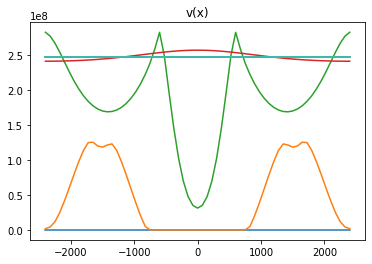

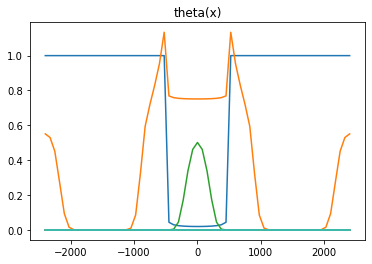

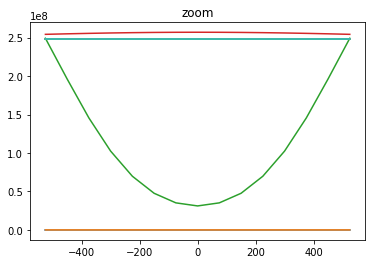

In [3]:
##Affichage
pas = max(1, N//10)

for n in range(0, N, pas):
    plt.plot(x, np.exp(Phi[n]))
plt.title('v(x)')
plt.show()

for n in range(0, N, pas):
    plt.plot(x, np.exp(Nu[n]))
plt.title('theta(x)')
plt.show()

for n in range(0, N, pas):
    plt.plot(x[25:40], np.exp(Phi[n])[25:40])
plt.title('zoom')
plt.show()

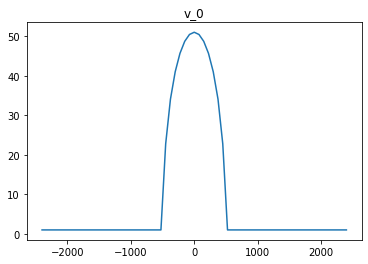

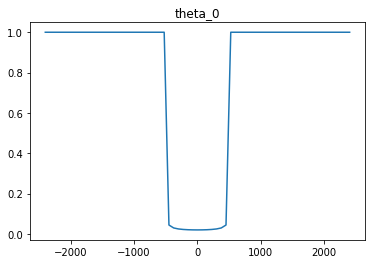

In [4]:
plt.plot(x, CIv)
plt.title('v_0')
plt.show()
plt.plot(x, CItheta)
plt.title('theta_0')
plt.show()

In [6]:
def rep(n, N):
    M = int(np.log10(N))
    m = int(np.log10(n))
    return "0"*(M-m) + str(n)

for n in range(1, N, 100):
    #plt.plot(x, np.exp(Phi[n]))
    plt.plot(x, Phi[n])
    plt.ylim(0, 21)
    plt.savefig(f"Phi-{rep(n, 10000)}.png", format='png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [10]:
print("0"*3+str(3))

0003


In [8]:
for n in range(1, 10000, 100):
    #plt.plot(x, np.exp(Nu[n]))
    plt.plot(x, Nu[n])
    plt.ylim(-20, 0)
    plt.savefig(f"Nu-{rep(n, 10000)}.png", format='png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

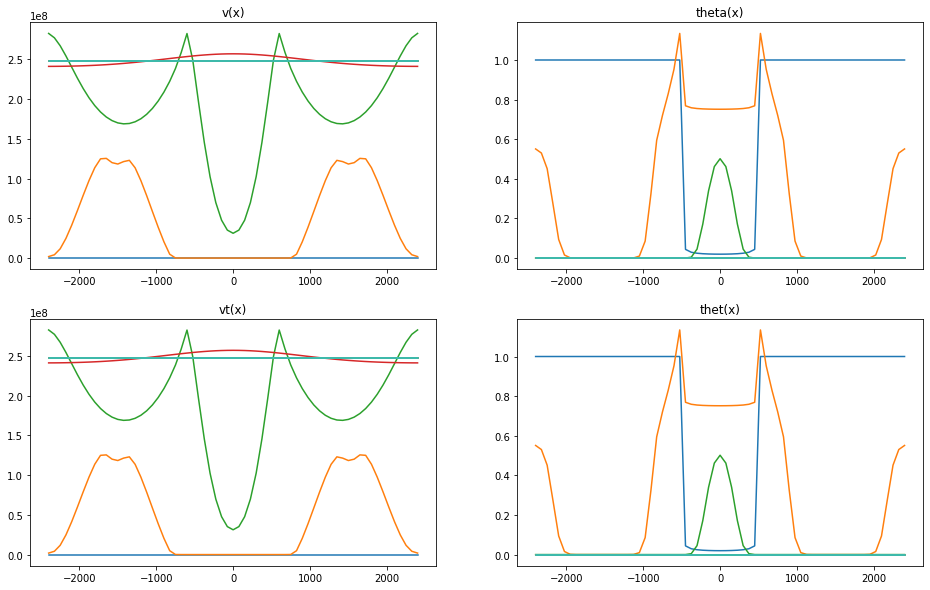

In [6]:
pas = max(1, N//10)

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
for n in range(0, N, pas):
    plt.plot(x, np.exp(Phi[n]))
plt.title('v(x)')

plt.subplot(2, 2, 2)
for n in range(0, N, pas):
    plt.plot(x, np.exp(Nu[n]))
plt.title('theta(x)')

plt.subplot(2, 2, 3)
for n in range(0, N, pas):
    plt.plot(x, np.exp(Phi[n]))
plt.title('vt(x)')

plt.subplot(2, 2, 4)
for n in range(0, N, pas):
    plt.plot(x, np.exp(Nu[n]))
plt.title('thet(x)')

plt.show()

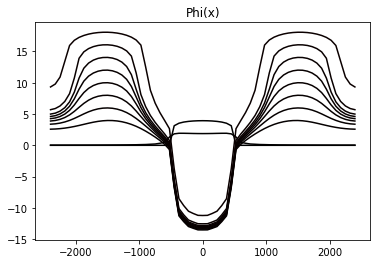

In [7]:
maxi = max(Phi[0])
reduc = 2

col = 0. + 0/(2*N)
plt.plot(x, Phi[0], color=(col, 0, 0))
for n in range(1, N):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = 0. + n/(2*N)
        plt.plot(x, Phi[n], color=(col, 0, 0))
plt.title('Phi(x)')
plt.show()

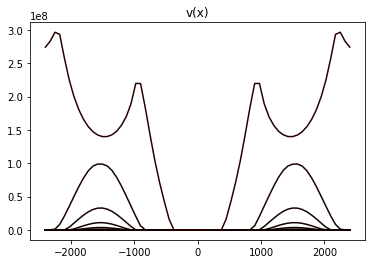

In [8]:
maxi = max(np.exp(Phi[0]))
reduc = 3

col = 0. + 0/(1*N)
plt.plot(x, np.exp(Phi[0]), color=(col, 0, 0))
for n in range(1, N):
    max_swap = max(np.exp(Phi[n]))
    if max_swap > maxi*reduc or max_swap < maxi/reduc:
        maxi = max_swap
        col = 0. + n/(1*N)
        plt.plot(x, np.exp(Phi[n]), color=(col, 0, 0))
plt.title('v(x)')
plt.show()

In [4]:
import sys
import os
import traceback
import optparse
import time
import logging


def wavelength_to_rgb(wavelength, gamma=0.8):

    '''This converts a given wavelength of light to an 
    approximate RGB color value. The wavelength must be given
    in nanometers in the range from 380 nm through 750 nm
    (789 THz through 400 THz).

    Based on code by Dan Bruton
    http://www.physics.sfasu.edu/astro/color/spectra.html
    '''

    wavelength = float(wavelength)
    if wavelength >= 380 and wavelength <= 440:
        attenuation = 0.3 + 0.7 * (wavelength - 380) / (440 - 380)
        R = ((-(wavelength - 440) / (440 - 380)) * attenuation) ** gamma
        G = 0.0
        B = (1.0 * attenuation) ** gamma
    elif wavelength >= 440 and wavelength <= 490:
        R = 0.0
        G = ((wavelength - 440) / (490 - 440)) ** gamma
        B = 1.0
    elif wavelength >= 490 and wavelength <= 510:
        R = 0.0
        G = 1.0
        B = (-(wavelength - 510) / (510 - 490)) ** gamma
    elif wavelength >= 510 and wavelength <= 580:
        R = ((wavelength - 510) / (580 - 510)) ** gamma
        G = 1.0
        B = 0.0
    elif wavelength >= 580 and wavelength <= 645:
        R = 1.0
        G = (-(wavelength - 645) / (645 - 580)) ** gamma
        B = 0.0
    elif wavelength >= 645 and wavelength <= 750:
        attenuation = 0.3 + 0.7 * (750 - wavelength) / (750 - 645)
        R = (1.0 * attenuation) ** gamma
        G = 0.0
        B = 0.0
    else:
        R = 0.0
        G = 0.0
        B = 0.0
    R *= 255
    G *= 255
    B *= 255
    return (int(R)/255, int(G)/255, int(B)/255)

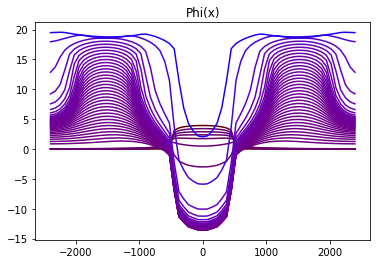

In [10]:
maxi = max(Phi[0])
reduc = 0.5

col = wavelength_to_rgb(380 + (750-380)*n/N)
plt.plot(x, Phi[0], color=col)
for n in range(1, N):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*n/N)
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')
plt.show()

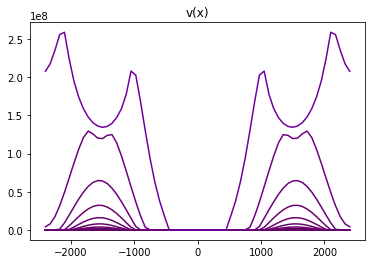

In [50]:
maxi = max(np.exp(Phi[0]))
reduc = 2

col = wavelength_to_rgb(380 + (750-380)*0/N)
plt.plot(x, np.exp(Phi[0]), color=col)
for n in range(1, N):
    max_swap = max(np.exp(Phi[n]))
    if max_swap > maxi*reduc or max_swap < maxi/reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*n/N)
        plt.plot(x, np.exp(Phi[n]), color=col)
plt.title('v(x)')
plt.show()

In [24]:
wavelength_to_rgb(380 + (750-380)*10/N)

(97, 0, 98)

In [30]:
wavelength_to_rgb(380 + (750-380)*0.6)

(1, 0, 0)

In [37]:
wavelength_to_rgb(530)

(0, 1, 0)

Text(0.5, 1.0, 'Phi(x)')

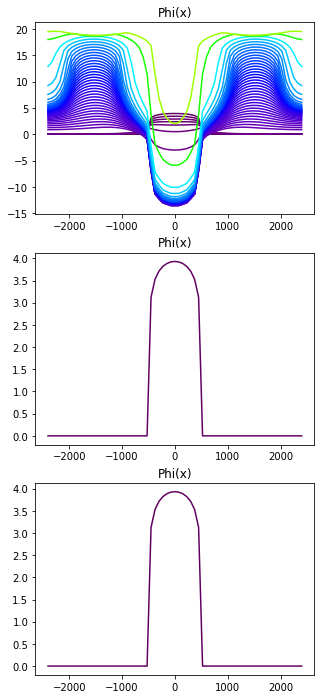

In [12]:
plt.figure(figsize=(5, 12))


plt.subplot(3, 1, 1)
maxi = max(Phi[0])
reduc = 0.5

col = wavelength_to_rgb(380 + (750-380)*0/(N//3))
plt.plot(x, Phi[0], color=col)
for n in range(1, N//3):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*n/(N//3))
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')

plt.subplot(3, 1, 2)
maxi = max(Phi[N//3])
reduc = 0.5

col = wavelength_to_rgb(380 + (750-380)*(N//3 - N//3)/(N//3))
plt.plot(x, Phi[0], color=col)
for n in range(N//3, 2*N//3):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*(n - N//3)/(N//3))
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')

plt.subplot(3, 1, 3)
maxi = max(Phi[2*N//3])
reduc = 0.5

col = wavelength_to_rgb(380 + (750-380)*(2*N//3 - 2*N//3)/(N//3))
plt.plot(x, Phi[0], color=col)
for n in range(2*N//3, N):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*(n - 2*N//3)/(N//3))
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')

In [ ]:
plt.figure(figsize=(5, 12))


plt.subplot(3, 1, 1)
maxi = max(Phi[0])
reduc = 0.5

col = wavelength_to_rgb(380 + (750-380)*0/(N//3))
plt.plot(x, Phi[0], color=col)
for n in range(1, N//3):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*n/(N//3))
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')

plt.subplot(3, 1, 2)
maxi = max(Phi[N//3])
reduc = 0.5

col = wavelength_to_rgb(380 + (750-380)*(N//3 - N//3)/(N//3))
plt.plot(x, Phi[0], color=col)
for n in range(N//3, 2*N//3):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*(n - N//3)/(N//3))
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')

plt.subplot(3, 1, 3)
maxi = max(Phi[2*N//3])
reduc = 0.5

col = wavelength_to_rgb(380 + (750-380)*(2*N//3 - 2*N//3)/(N//3))
plt.plot(x, Phi[0], color=col)
for n in range(2*N//3, N):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*(n - 2*N//3)/(N//3))
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')

Text(0.5, 1.0, 'Phi(x)')

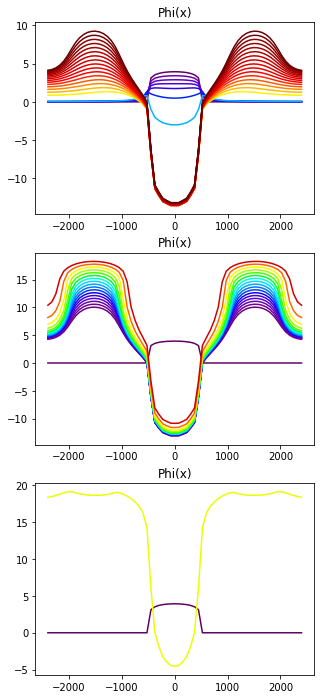

In [11]:
plt.figure(figsize=(5, 12))


plt.subplot(3, 1, 1)
maxi = max(Phi[0])
reduc = 0.5

col = wavelength_to_rgb(380)
plt.plot(x, Phi[0], color=col)
for n in range(1, N//20):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*n/(N//20))
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')

plt.subplot(3, 1, 2)
maxi = max(Phi[N//20])
reduc = 0.5

col = wavelength_to_rgb(380)
plt.plot(x, Phi[0], color=col)
for n in range(N//20, 2*N//20):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*(n - N//20)/(N//20))
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')

plt.subplot(3, 1, 3)
maxi = max(Phi[2*N//20])
reduc = 0.5

col = wavelength_to_rgb(380)
plt.plot(x, Phi[0], color=col)
for n in range(2*N//20, 3*N//20):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*(n - 2*N//20)/(N//20))
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')

Text(0.5, 1.0, 'Phi(x)')

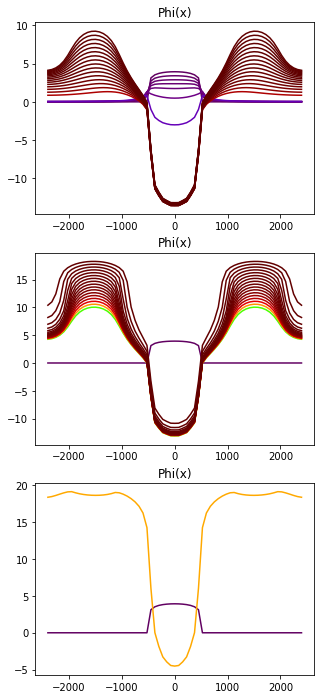

In [14]:
plt.figure(figsize=(5, 12))


plt.subplot(3, 1, 1)
maxi = max(Phi[0])
reduc = 0.5

col = wavelength_to_rgb(380)
plt.plot(x, Phi[0], color=col)
for n in range(1, N//20):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*temps[n]/temps[N//20])
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')

plt.subplot(3, 1, 2)
maxi = max(Phi[N//20])
reduc = 0.5

col = wavelength_to_rgb(380)
plt.plot(x, Phi[0], color=col)
for n in range(N//20, 2*N//20):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*(temps[n]-temps[N//20])/(temps[2*N//20]-temps[N//20]))
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')

plt.subplot(3, 1, 3)
maxi = max(Phi[2*N//20])
reduc = 0.5

col = wavelength_to_rgb(380)
plt.plot(x, Phi[0], color=col)
for n in range(2*N//20, 3*N//20):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*(temps[n]-temps[2*N//20])/(temps[3*N//20]-temps[2*N//20]))
        plt.plot(x, Phi[n], color=col)
plt.title('Phi(x)')

In [12]:
Delta = [[0]*len(Phi[0])]

for n in range(1, N):
    vnn = np.exp(Phi[n])
    vn = np.exp(Phi[n-1])
    Delta.append([Delta[-1][x] + (vnn[x] - vn[x])/(temps[n] - temps[n-1]) for x in range(I+1)])

In [20]:
len(Delta[1])

65

In [5]:
np.log(10)

2.302585092994046

In [8]:
Thau = [[0]*len(Phi[0])]

for n in range(1, N):
    vnn = np.exp(Phi[n])
    vn = np.exp(Phi[n-1])
    tnn = np.exp(Nu[n])
    tn = np.exp(Nu[n-1])
    Thau.append([Thau[-1][x] + (a*np.log(vnn[x]/vn[x]) + b*np.log(tnn[x]/tn[x]))/(temps[n] - temps[n-1]) for x in range(I+1)])

In [9]:
len(Thau[1])

65

In [10]:
Thau[1]

[0.00037493991227976553,
 0.0003770531058722326,
 0.0003813338660753047,
 0.0003878945543091933,
 0.00039691331235891097,
 0.00040864723797027824,
 0.0004234531433988543,
 0.0004418194898126086,
 0.00046441499394987755,
 0.0004921615086145997,
 0.0005263399201440661,
 0.0005687351014267601,
 0.0006218139063313957,
 0.0006889004697789245,
 0.0007742566428563918,
 0.0008828888762053868,
 0.0010198003261871068,
 0.001188334328106227,
 0.0013872984613533322,
 0.0016068288551517552,
 0.001823537946349276,
 0.001996354590630663,
 0.002065364390131705,
 0.001956382808424088,
 0.0015932964306650116,
 0.0009179497931703428,
 -8.618638484331283e-05,
 -0.0013738258193902386,
 -0.002829812620613549,
 -0.004279550423405584,
 -0.0055184582193505555,
 -0.006354031140337197,
 -0.0066491104234531195,
 -0.006354031140337197,
 -0.0055184582193505555,
 -0.004279550423405584,
 -0.002829812620613549,
 -0.0013738258193902386,
 -8.618638484331283e-05,
 0.0009179497931703428,
 0.0015932964306650116,
 0.0019563

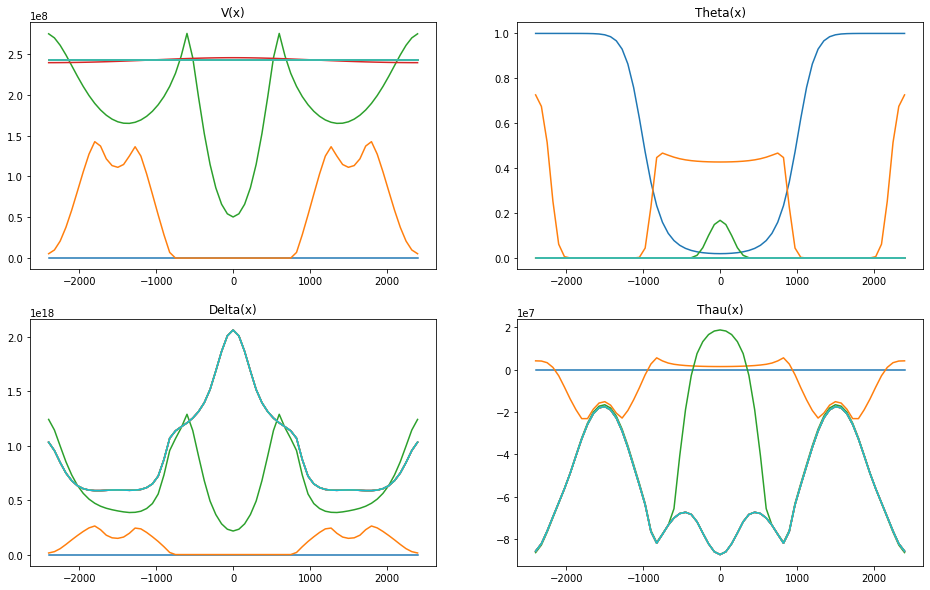

In [13]:
pas = max(1, N//10)

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
for n in range(0, N, pas):
    plt.plot(x, np.exp(Phi[n]))
plt.title('V(x)')

plt.subplot(2, 2, 2)
for n in range(0, N, pas):
    plt.plot(x, np.exp(Nu[n]))
plt.title('Theta(x)')

plt.subplot(2, 2, 3)
for n in range(0, N, pas):
    plt.plot(x, Delta[n])
plt.title('Delta(x)')

plt.subplot(2, 2, 4)
for n in range(0, N, pas):
    plt.plot(x, Thau[n])
plt.title('Thau(x)')

plt.show()

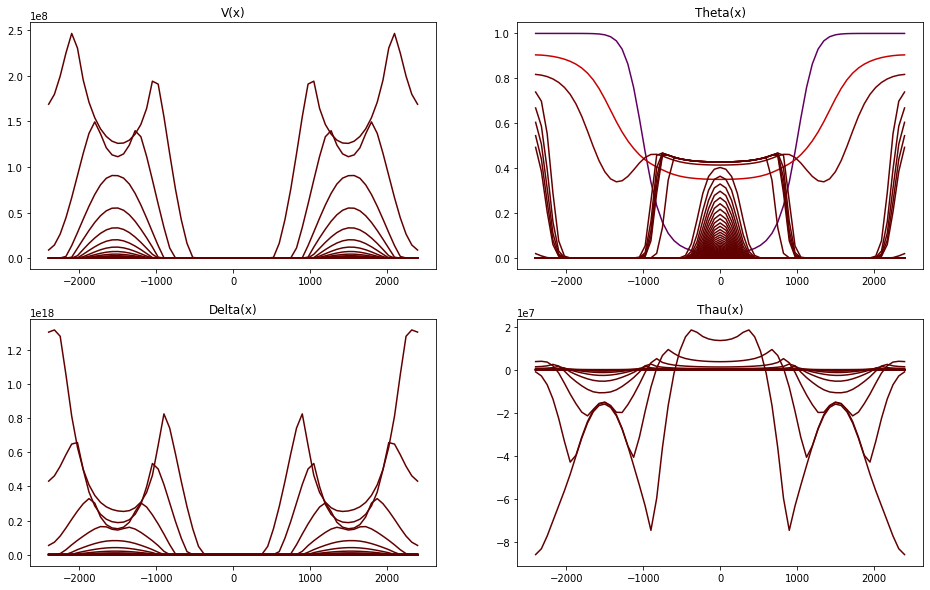

In [26]:
pas = max(1, N//10)

plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
maxi = max(Phi[0])
reduc = 0.5
col = wavelength_to_rgb(380)
plt.plot(x, np.exp(Phi[0]), color=col)
for n in range(1, N):
    max_swap = max(Phi[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*temps[n]/temps[N])
        plt.plot(x, np.exp(Phi[n]), color=col)
plt.title('V(x)')


plt.subplot(2, 2, 2)
maxi = max(Nu[0])
reduc = 0.1
col = wavelength_to_rgb(380)
plt.plot(x, np.exp(Nu[0]), color=col)
for n in range(1, N):
    max_swap = max(Nu[n])
    if max_swap > maxi + reduc or max_swap < maxi - reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*temps[n]/temps[N])
        plt.plot(x, np.exp(Nu[n]), color=col)
plt.title('Theta(x)')

plt.subplot(2, 2, 3)
maxi = max(Delta[0])
reduc = 2
col = wavelength_to_rgb(380)
plt.plot(x, Delta[0], color=col)
for n in range(1, N):
    max_swap = max(Delta[n])
    if max_swap > maxi * reduc or max_swap < maxi / reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*temps[n]/temps[N])
        plt.plot(x, Delta[n], color=col)
plt.title('Delta(x)')

plt.subplot(2, 2, 4)
maxi = max(np.abs(Thau[0]))
reduc = 2
col = wavelength_to_rgb(380)
plt.plot(x, Thau[0], color=col)
for n in range(1, N):
    max_swap = max(np.abs(Thau[n]))
    if max_swap > maxi * reduc or max_swap < maxi / reduc:
        maxi = max_swap
        col = wavelength_to_rgb(380 + (750-380)*temps[n]/temps[N])
        plt.plot(x, Thau[n], color=col)
plt.title('Thau(x)')

plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  if __name__ == '__main__':


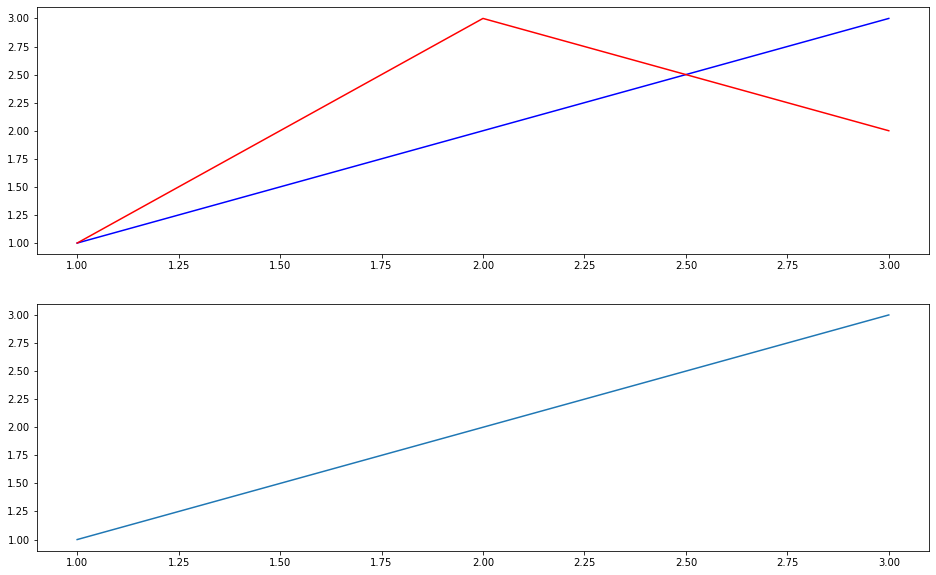

In [2]:
plt.figure(figsize=(16, 10))

plt.subplot(2,1,1)
plt.plot([1, 2, 3], [1, 2, 3], color="blue")

plt.subplot(2,1,2)
plt.plot([1, 2, 3], [1, 2, 3])

plt.subplot(2,1,1)
plt.plot([1, 2, 3], [1, 3, 2], color="red")

plt.show()